<h1>Cool Maths</h1>

<h2>Local Expensive Min</h2>
<h3>Libraries</h3>

In [80]:
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
from pprint import pprint
import asyncio
import scipy
import math
import bisect
from IPython import display
from IPython.display import HTML
from numpy.polynomial import Polynomial
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.animation import HTMLWriter

from scipy import optimize as opt
from scipy.interpolate import splrep, splev, interp1d, CubicSpline

%reload_ext blackcellmagic


<h3>Functions</h3>

In [81]:
def f(x):
    return np.sin(x) + 0.05 * x ** 2
    

def slow(x):
    #await asyncio.sleep(0.01)
    y = f(x)
    return y + np.random.normal(0, 0.2, size=np.size(y))


def fit(X, Y):
    if X.size == 2:
        return Polynomial.fit(X, Y, deg=1)
    if X.size == 3:
        return Polynomial.fit(X, Y, deg=2)
    spl = splrep(X, Y, s = 0.2)
    return lambda x: splev(x, spl)


async def uncertainty(fit, limits, X, x):
    async def height(fit, limits, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        y = -fit(x)
        y -= y.min()
        y /= y.max()
        return y + 0.01

    async def sparcity(fit, limits, X, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        prob = np.zeros_like(x)
        for j, point in enumerate(x):
            prob[j] = np.min(np.abs(X-point))
        return prob

    probY = height(approx, limits, x)
    probX = sparcity(approx, limits, X, x)
    return await (probY) * await (probX)

    


This Method = -1.4061394683602604
This Method = -1.411411411411411
fminbound with same number of iterations = [-1.44572179]
fminbound with 500 iterations max = -1.427552619970902


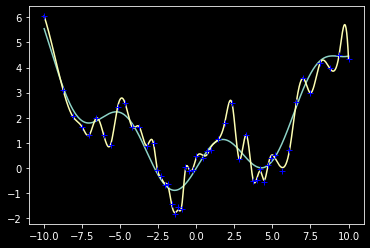

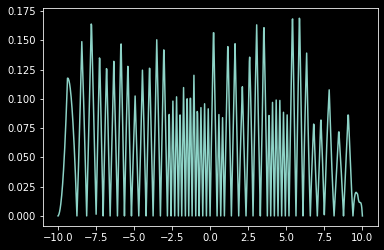

In [82]:
limits = np.array([-10, 10], dtype=float)
line = None
funIt = 50
x = np.linspace(*limits, 1000)
plt.figure(0)

plt.plot(x, f(x))

X = limits - (limits-np.mean(limits))/4
Y = slow(X)
xs = np.zeros([funIt-2, len(x)])
ys = np.zeros([funIt-2, len(x)])

for i in range(funIt-2):
    approx = fit(X, Y)
    error = await uncertainty(fit, limits, X, x)
    nxt = np.argmax(error)

    index = bisect.bisect(X, x[nxt])
    X = np.insert(X, index, x[nxt])
    Y = np.insert(Y, index, slow(x[nxt]))
    
    xs[i,:] = x
    ys[i,:] = approx(x)
    
approx = fit(X, Y)
error = await uncertainty(approx, limits, X, x)
plt.figure(0)
plt.plot(x, approx(x))
plt.figure(0)
plt.plot(X, Y, "b+")
plt.figure(1)
plt.plot(x, error)

print(f"This Method = {opt.fminbound(approx, *limits, maxfun=1000, disp = 0)}")
print(f"This Method = {x[np.argmin(approx(x))]}")
print(f"fminbound with same number of iterations = {opt.fminbound(slow, *limits, disp = 0, maxfun = funIt)}")
print(f"fminbound with 500 iterations max = {opt.fminbound(f, *limits, disp = 0)}")


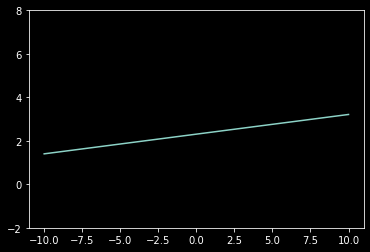

In [83]:
Figure = plt.figure()
lines_plotted = plt.plot([])
line_plotted = lines_plotted[0]
plt.xlim([-11, 11])
plt.ylim((-2, 8))
pltName = "optimiser.html"

def createGif(frame, x, y):
    line_plotted.set_data((x[frame,:], y[frame,:]))


anim_created = FuncAnimation(
    Figure, lambda i: createGif(i, xs, ys), frames=funIt-2)

writer = HTMLWriter(fps = 2)
anim_created.save(pltName, writer=writer)
HTML(pltName)


In [97]:
trueValue = -1.42755177897199
size = [15, 50]
epsilon_linspace = np.zeros(size)
epsilon_fmin = np.zeros(size)
epsilon_aLearning = np.zeros(size)
x = np.linspace(*limits, 1000)

for j in range(size[1]):
    _X = limits - (limits-np.mean(limits))/4
    _Y = slow(_X)
    for s in range(size[0]):
        for i in range(s):
            _approx = fit(_X, _Y)
            _error = await uncertainty(fit, limits, _X, x)
            _nxt = np.argmax(_error)

            _index = bisect.bisect(_X, x[_nxt])
            _X = np.insert(_X, _index, x[_nxt])
            _Y = np.insert(_Y, _index, slow(x[_nxt]))
        _approx = fit(_X, _Y)
        _index = min(max(1, np.argmin(_approx(x))), len(x)-2)
        epsilon_aLearning[s, j] = opt.fminbound(_approx, x[_index-1], x[_index+1], maxfun=1000, disp =0) - trueValue
        print(f"\r{j,s}", end="")

for j in range(size[1]):
    for i in range(2, size[0]+2):
        xbar = np.linspace(*limits, i)
        epsilon_linspace[i-2, j] = xbar[np.argmin(slow(xbar))] - trueValue
        epsilon_fmin[i-2, j] = opt.fminbound(slow, *limits, disp=0, maxfun=i) - trueValue


(7, 13)

/home/rjb255/.local/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:509: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


(34, 12)

/home/rjb255/.local/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:509: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


(49, 14)

In [85]:
np.savetxt('epsilon_fmin.csv',epsilon_fmin)
np.savetxt('epsilon_aLearning.csv',epsilon_aLearning)
np.savetxt('epsilon_linspace.csv',epsilon_linspace)


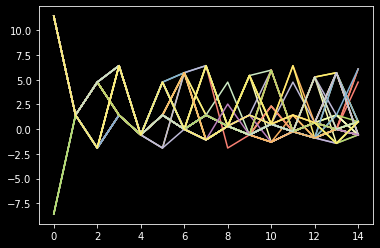

In [86]:
plt.plot(epsilon_linspace)

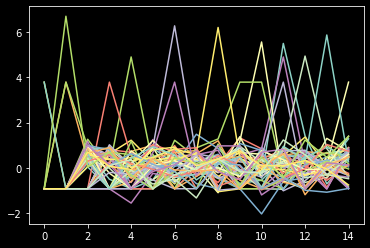

In [87]:
plt.plot(epsilon_fmin)

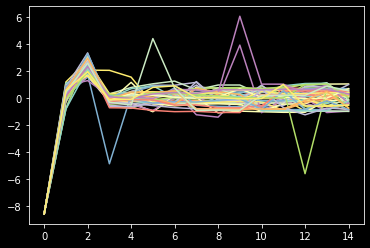

In [88]:
plt.plot(epsilon_aLearning)

In [93]:
x[_index+1]

-9.97997997997998